<a href="https://colab.research.google.com/github/bhuvighosh3/Directed-Adversarial-Training-for-Comprehensive-Robustification-of-CNNs/blob/main/Research_Paper_AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import torch
from torch import nn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms
from torchvision.transforms import ToTensor
from torchvision.models import vgg16
from torchvision.models import resnet50
import torch.optim as optim

!pip install adversarial-robustness-toolbox
from art.attacks.evasion import DeepFool as DeepFool
from art.attacks.evasion import CarliniL2Method
from art.estimators.classification import PyTorchClassifier
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, Subset, random_split
from PIL import Image
from os import listdir
import natsort
from natsort import natsorted
from torchvision.io import read_image
from torchvision import transforms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.7 MB/s eta 0:00:00


In [ ]:
#FGSM & PGD
!pip install -qq -e git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans
import sys
sys.path.append('/content/src/cleverhans')
import cleverhans

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.5 MB/s eta 0:00:00


In [ ]:
!pip install adversarial-robustness-toolbox
from art.attacks.evasion import DeepFool , SaliencyMapMethod, CarliniL2Method
from art.estimators.classification import PyTorchClassifier

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

!wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip
!wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip

--2024-02-19 13:57:26--  https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip
Resolving btsd.ethz.ch (btsd.ethz.ch)... 129.132.52.168, 2001:67c:10ec:36c2::168
Connecting to btsd.ethz.ch (btsd.ethz.ch)|129.132.52.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 174298785 (166M) [application/zip]
Saving to: ‘BelgiumTSC_Training.zip’

BelgiumTSC_Training 100%[===================>] 166.22M  6.06MB/s    in 28s     

2024-02-19 13:57:55 (5.91 MB/s) - ‘BelgiumTSC_Training.zip’ saved [174298785/174298785]

--2024-02-19 13:57:55--  https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip
Resolving btsd.ethz.ch (btsd.ethz.ch)... 129.132.52.168, 2001:67c:10ec:36c2::168
Connecting to btsd.ethz.ch (btsd.ethz.ch)|129.132.52.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77877833 (74M) [application/zip]
Saving to: ‘BelgiumTSC_Testing.zip’

BelgiumTSC_Testing. 100%[===================>]  74.27M  6.03MB/s    in 13s     


In [ ]:
!unzip 'BelgiumTSC_Training.zip'
!unzip 'BelgiumTSC_Testing.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Training/00036/01285_00000.ppm  
  inflating: Training/00036/01285_00001.ppm  
  inflating: Training/00036/01285_00002.ppm  
  inflating: Training/00036/01457_00000.ppm  
  inflating: Training/00036/01457_00001.ppm  
  inflating: Training/00036/01457_00002.ppm  
  inflating: Training/00036/01606_00000.ppm  
  inflating: Training/00036/01606_00001.ppm  
  inflating: Training/00036/01606_00002.ppm  
  inflating: Training/00036/01687_00000.ppm  
  inflating: Training/00036/01687_00001.ppm  
  inflating: Training/00036/01687_00002.ppm  
  inflating: Training/00036/GT-00036.csv  
   creating: Training/00037/
  inflating: Training/00037/00099_00000.ppm  
  inflating: Training/00037/00099_00001.ppm  
  inflating: Training/00037/00099_00002.ppm  
  inflating: Training/00037/00100_00000.ppm  
  inflating: Training/00037/00163_00000.ppm  
  inflating: Training/00037/00163_00001.ppm  
  inflating: Training/00037/00163_00002.ppm  
  i

In [ ]:
class BL_Dataset(Dataset):
    def __init__(self, Data, transform=None):
        if Data == "train":
            directory = 'Training/'
        elif Data == "test":
            directory = 'Testing/'

        folder_list = natsorted(listdir(directory))
        folder_list = folder_list[:-1]
        flist = []
        label_list = []
        for subfolder in folder_list:
          subfiles = natsorted(listdir(directory+subfolder))
          subfiles = subfiles[:-1]
          for subfile in subfiles:
            flist.append(directory+subfolder+'/'+subfile)
            label_list.append(int(subfolder))

        self.images = [Image.open(f) for f in flist]
        self.labels = torch.Tensor(label_list).long()

        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
         image = self.images[idx]
         label = self.labels[idx]
         if self.transform:
             image = self.transform(image)
         return image, label

In [ ]:
dataset = BL_Dataset('train', transforms.Compose([transforms.ToTensor(),
                                                 transforms.Resize((32,32))
                                                 ]))
test_dataset = BL_Dataset('test', transforms.Compose([transforms.ToTensor(),
                                                      transforms.Resize((32,32))
                                                     ]))
train_dataset, validation_dataset = random_split(dataset, [round(.80*len(dataset)),
                                                           int(.20*len(dataset))])

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=64)
validation_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=64)

In [ ]:
len(train_dataset)

3660

In [ ]:
len(test_dataset)

2520

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


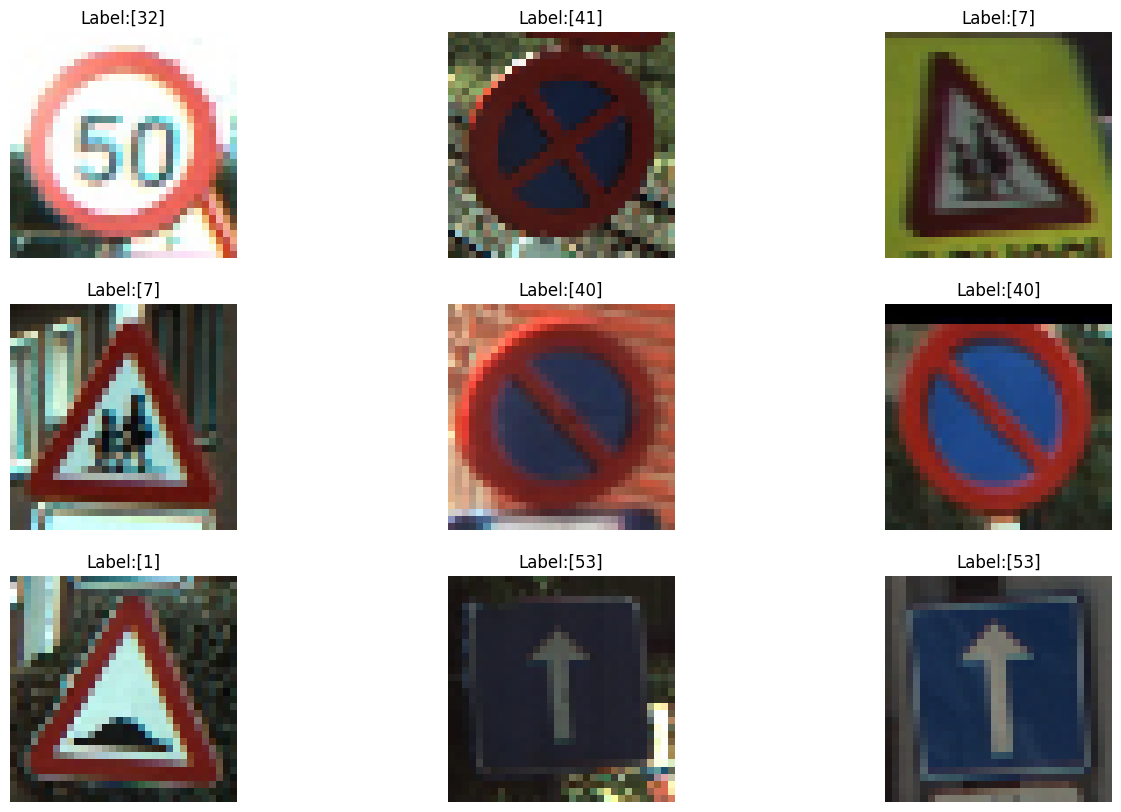

In [ ]:
plt.figure(figsize=(16, 10))
data = iter(train_dataloader)
for n in range(9):
    ax = plt.subplot(3, 3, n+1)
    image, labels = next(data)
    img = image[0].permute(1, 2, 0).squeeze()
    plt.imshow(img.numpy())
    plt.title('Label:' + str([int(labels[0])]))
    plt.axis('off')


##1-VGG16

In [ ]:
#VGG16
VGG16 = vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 65.4MB/s]


In [ ]:
VGG16.classifier._modules['6'] = nn.Linear(4096, 62)

In [ ]:
VGG16.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
#Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGG16.parameters(), lr=0.001, momentum=0.9)

epoch_num = 10
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]

        inputs, labels = data
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = VGG16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))

    training_loss_plot.append(running_loss)
    training_accuracy_plot.append(correct/total)

    #validation
    running_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
      for i, data in enumerate(validation_dataloader, 0):
          # get the inputs; data is a list of [inputs, labels]

          inputs, labels = data
          labels = labels.type(torch.LongTensor)
          inputs, labels = inputs.cuda(), labels.cuda()

          # forward
          outputs = VGG16(inputs)
          loss = criterion(outputs, labels)

          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    val_loss_plot.append(running_loss)
    val_accuracy_plot.append(correct/total)
print('Finished Training')
print("validation ", val_accuracy_plot[epoch_num -1],"training", training_accuracy_plot[epoch_num-1])

Finished Training
validation  0.9584699453551913 training 0.9877049180327869


In [ ]:
VGG16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

###plot

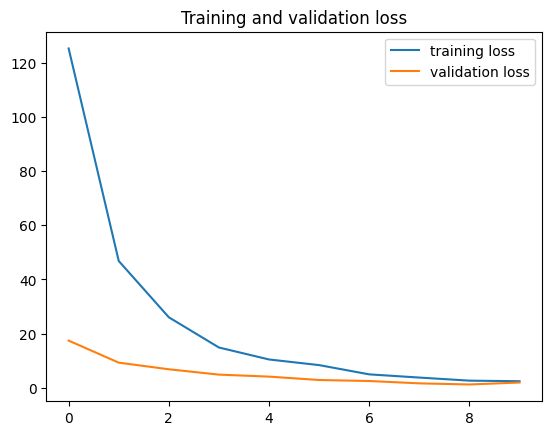

Text(0.5, 1.0, 'Training and validation accuracy')

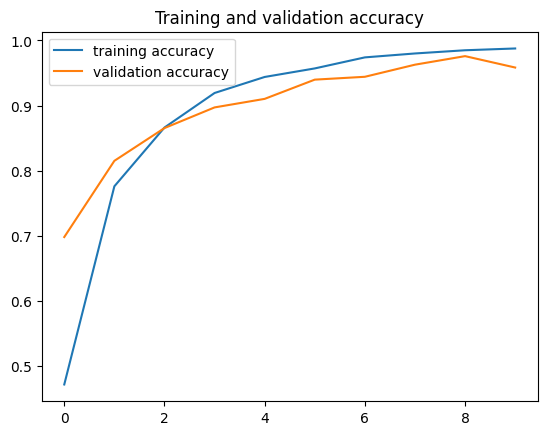

In [ ]:
#VGG16 plot
plt.plot(training_loss_plot)
plt.plot(val_loss_plot)
plt.title('Training and validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()
plt.plot(training_accuracy_plot)
plt.legend(['training loss', 'validation loss'])
plt.plot(val_accuracy_plot)
plt.legend(['training accuracy', 'validation accuracy'])
plt.title('Training and validation accuracy')

###Test

In [ ]:
#Test
correct = 0
total = 0
with torch.no_grad():
  for data in test_dataloader:
      images, labels = data
      labels = labels.type(torch.LongTensor)
      images = images.cuda()
      labels = labels.cuda()
      outputs = VGG16(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %f %%' % (
100 * correct / total))

Accuracy of the network on the test images: 91.666667 %


##2-ResNet50

In [ ]:
#ResNet50
ResNet50 = torchvision.models.resnet50(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


In [ ]:
ResNet50._modules['6'] = nn.Linear(4096, 62)

###Train

In [ ]:
#Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNet50.parameters(), lr=0.001) #, momentum=0.9)

epoch_num = 10
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]

        inputs, labels = data
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.cuda(), labels.cuda()
        model = ResNet50

        if torch.cuda.is_available():
           model.cuda()

        optimizer.zero_grad()


        outputs = ResNet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))

    training_loss_plot.append(running_loss)
    training_accuracy_plot.append(correct/total)

    #validation
    running_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
      for i, data in enumerate(validation_dataloader, 0):
          # get the inputs; data is a list of [inputs, labels]

          inputs, labels = data
          labels = labels.type(torch.LongTensor)
          inputs, labels = inputs.cuda(), labels.cuda()

          outputs = ResNet50(inputs)
          loss = criterion(outputs, labels)

          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    val_loss_plot.append(running_loss)
    val_accuracy_plot.append(correct/total)
print('Finished Training')
print("validation ", val_accuracy_plot[epoch_num -1],"training", training_accuracy_plot[epoch_num-1])

Finished Training
validation  0.9639344262295082 training 0.9734972677595628


In [ ]:
ResNet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

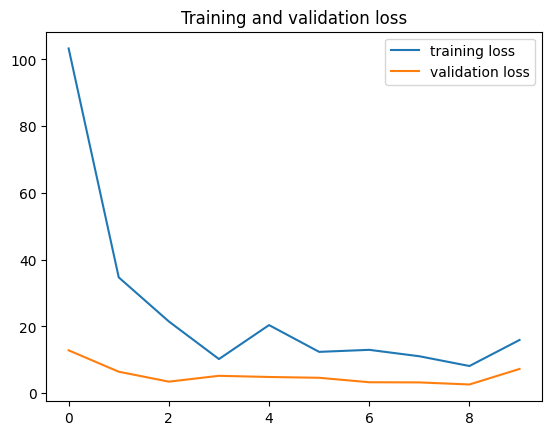

Text(0.5, 1.0, 'Training and validation accuracy')

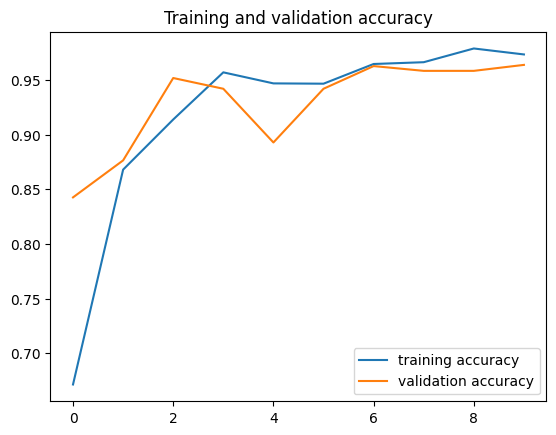

In [ ]:
#ResNet50 plot
plt.plot(training_loss_plot)
plt.plot(val_loss_plot)
plt.title('Training and validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()
plt.plot(training_accuracy_plot)
plt.legend(['training loss', 'validation loss'])
plt.plot(val_accuracy_plot)
plt.legend(['training accuracy', 'validation accuracy'])
plt.title('Training and validation accuracy')


In [ ]:
#Test
correct = 0
total = 0
with torch.no_grad():
  for data in test_dataloader:
      images, labels = data
      labels = labels.type(torch.LongTensor)
      images = images.cuda()
      labels = labels.cuda()
      outputs = ResNet50(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %f %%' % (
100 * correct / total))

Accuracy of the network on the test images: 95.634921 %


##3- Results and discussion:


#### Table 1: Classification accuracy of VGG16 and ResNet50 on the BTSC dataset

\begin{array}{|c|c|c|c|}
\hline
\textbf{Model} & \text{Train ACC(%)} & \text{Validation ACC(%)} & \text{Test ACC(%)} \\
\hline
\textbf{VGG16} & 98.57 & 96.61 & 92.61\\
\textbf{ResNet50} & 99.26 & 96.72 & 96.07 \\
\hline
\end{array}

#Task 2: non-targeted white-box evasion attacks against the deep learning models.

##1-VGG16

In [ ]:
epsilons = [0, 0.1, 0.15]

###FSGM-VGG16

In [ ]:
#FSGM- VGG16
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=64)
validation_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=64)

correct = 0
total = 0
accuracies_FSGM = []

# Use the complete testing dataset
sub_dataset = test_dataset
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
    print(epsilon)
    accuracy = []
    for data in subsest_dataloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()

        # Assuming fast_gradient_method is a function implementing FGSM
        adversarial_images = fast_gradient_method(VGG16, images, epsilon, np.inf)

        outputs = VGG16(adversarial_images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        accuracy.append(correct / total)

    accuracies_FSGM.append(np.mean(accuracy))

print(accuracies_FSGM)

0
0.1
0.15
[0.8853877400428616, 0.7093364308949873, 0.5217112195943882]


In [ ]:
from torch.utils.data import ConcatDataset

# Assuming you have already defined your test_dataset and validation_dataset

# Use the whole testing dataset
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=64)
validation_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=64)

correct = 0
total = 0
accuracies_FSGM = []

# Use the complete testing dataset
sub_dataset = test_dataset
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
    print(epsilon)
    accuracy = []
    for data_original, data_perturbed in zip(test_dataloader, subsest_dataloader):
        images_original, labels_original = data_original
        images_perturbed, labels_perturbed = data_perturbed

        images_original = images_original.cuda()
        labels_original = labels_original.cuda()

        images_perturbed = images_perturbed.cuda()
        labels_perturbed = labels_perturbed.cuda()

        # Combine original and perturbed images
        mixed_images = torch.cat([images_original, images_perturbed], dim=0)
        mixed_labels = torch.cat([labels_original, labels_perturbed], dim=0)

        # Assuming fast_gradient_method is a function implementing FGSM
        adversarial_images = fast_gradient_method(VGG16, images_perturbed, epsilon, np.inf)

        outputs = VGG16(mixed_images)
        _, predicted = torch.max(outputs.data, 1)

        total += mixed_labels.size(0)
        correct += (predicted == mixed_labels).sum().item()

        accuracy.append(correct / total)

    accuracies_FSGM.append(np.mean(accuracy))

print(accuracies_FSGM)

0
0.1
0.15
[0.9055019605953852, 0.9159147137541328, 0.9156067679137594]


### Training on adversarial images:

In [ ]:
epsilon

0.15

In [ ]:
# Assuming VGG16 is your model and you have already defined your dataloaders and datasets

# Define your optimizer and loss function
optimizer = optim.SGD(VGG16.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Train the model on perturbed images
num_epochs = 10  # You can adjust this as needed

for epoch in range(num_epochs):
    VGG16.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in train_dataloader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # Generate adversarial examples
        perturbed_inputs = fast_gradient_method(VGG16, inputs, epsilon, np.inf)

        optimizer.zero_grad()

        # Forward pass
        outputs = VGG16(perturbed_inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_dataloader)}, Accuracy: {100 * correct / total}%')

print('Finished Training')

Epoch 1/10, Loss: 2.6656026038630256, Accuracy: 33.442622950819676%
Epoch 2/10, Loss: 1.8305165274389859, Accuracy: 46.939890710382514%
Epoch 3/10, Loss: 1.5665493915820945, Accuracy: 52.595628415300546%
Epoch 4/10, Loss: 1.4160005686611965, Accuracy: 56.50273224043716%
Epoch 5/10, Loss: 1.3557296960518277, Accuracy: 57.486338797814206%
Epoch 6/10, Loss: 1.2195794387110348, Accuracy: 61.47540983606557%
Epoch 7/10, Loss: 1.2059890966990898, Accuracy: 61.0655737704918%
Epoch 8/10, Loss: 1.1393018087436413, Accuracy: 63.90710382513661%
Epoch 9/10, Loss: 1.101492322724441, Accuracy: 65.1639344262295%
Epoch 10/10, Loss: 1.0105289323576565, Accuracy: 67.59562841530055%
Finished Training


In [ ]:
torch.save(VGG16.state_dict(), 'vgg16_model.pth')
torch.save(optimizer.state_dict(), 'optimizer_state.pth')
additional_info = {
    'num_epochs': num_epochs,
    'epsilon': epsilon
}

In [ ]:
import pickle

In [ ]:
with open('additional_info.pkl', 'wb') as f:
    pickle.dump(additional_info, f)

print('Model and optimizer state saved.')

Model and optimizer state saved.


In [ ]:
VGG16.load_state_dict(torch.load('vgg16_model.pth'))
VGG16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
correct_test = 0
total_test = 0

In [ ]:
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = VGG16(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print(f'Accuracy on the test dataset: {100 * correct_test / total_test}%')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy on the test dataset: 88.61111111111111%


In [ ]:
VGG16.load_state_dict(torch.load('vgg16_model.pth'))
VGG16.eval()

# Evaluate on the original test dataset
total_test = 0
correct_test = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = VGG16(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print(f'Accuracy on the original test dataset: {100 * correct_test / total_test}%')

# Evaluate on the perturbed dataset using FGSM for the entire test dataset
correct = 0
total = 0
accuracies_FSGM = []

# Use the complete test dataset
perturbed_dataloader = DataLoader(test_dataset, batch_size=64)

for epsilon in epsilons:
    print(f'Evaluating with epsilon={epsilon}')
    accuracy = []
    for data in perturbed_dataloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()

        # Generate perturbed images using FGSM
        adversarial_images = fast_gradient_method(VGG16, images, epsilon, np.inf)

        # Model prediction on perturbed images
        outputs = VGG16(adversarial_images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy.append(correct / total)

    accuracies_FSGM.append(np.mean(accuracy))

print(f'Accuracy on the perturbed dataset using FGSM: {accuracies_FSGM}')

In [ ]:
# Load the saved model state dict
VGG16.load_state_dict(torch.load('vgg16_model.pth'))
VGG16.eval()

# Evaluate on the original test dataset
total_test = 0
correct_test = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = VGG16(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print(f'Accuracy on the original test dataset: {100 * correct_test / total_test}%')

# Evaluate on a mixture of normal and perturbed images
correct_mixed = 0
total_mixed = 0

# Use the complete test dataset for both normal and perturbed images
normal_dataloader = DataLoader(test_dataset, batch_size=64)
perturbed_dataloader = DataLoader(test_dataset, batch_size=64)

for epsilon in epsilons:
    print(f'Evaluating with epsilon={epsilon}')
    accuracy_mixed = []
    for data_normal, data_perturbed in zip(normal_dataloader, perturbed_dataloader):
        images_normal, labels_normal = data_normal
        images_perturbed, labels_perturbed = data_perturbed

        images_normal = images_normal.cuda()
        labels_normal = labels_normal.cuda()

        images_perturbed = fast_gradient_method(VGG16, images_perturbed.cuda(), epsilon, np.inf)
        labels_perturbed = labels_perturbed.cuda()

        # Combine normal and perturbed images
        mixed_images = torch.cat([images_normal, images_perturbed], dim=0)
        mixed_labels = torch.cat([labels_normal, labels_perturbed], dim=0)

        # Model prediction on mixed images
        outputs_mixed = VGG16(mixed_images)
        _, predicted_mixed = torch.max(outputs_mixed.data, 1)

        total_mixed += mixed_labels.size(0)
        correct_mixed += (predicted_mixed == mixed_labels).sum().item()
        accuracy_mixed.append(correct_mixed / total_mixed)

    print(f'Accuracy on the mixture of normal and perturbed images with epsilon={epsilon}: {accuracy_mixed[-1] * 100}%')

Accuracy on the original test dataset: 86.7063492063492%
Evaluating with epsilon=0
Accuracy on the mixture of normal and perturbed images with epsilon=0: 86.70634920634922%
Evaluating with epsilon=0.1
Accuracy on the mixture of normal and perturbed images with epsilon=0.1: 80.73412698412699%
Evaluating with epsilon=0.15
Accuracy on the mixture of normal and perturbed images with epsilon=0.15: 78.2473544973545%


###PGD-VGG16

In [ ]:
#PGD-VGG16
correct = 0
total = 0
accuracies_PGD =[]
sub_dataset=test_dataset
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    # labels = labels.type(torch.LongTensor)
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = projected_gradient_descent(model_fn = VGG16, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

In [ ]:
epsilons=[0,0.1,0.15]
# Split the test dataset into normal and perturbed subsets
normal_data, perturbed_data = train_test_split(test_dataset, test_size=0.5)

# Create dataloaders for normal and perturbed images
normal_dataloader = DataLoader(normal_data, shuffle=True, batch_size=64)
perturbed_dataloader = DataLoader(perturbed_data, shuffle=True, batch_size=64)

# Combine normal and perturbed datasets to create a hybrid dataset
hybrid_dataset = ConcatDataset([normal_data, perturbed_data])
hybrid_dataloader = DataLoader(hybrid_dataset, shuffle=True, batch_size=64)

correct_hybrid = 0
total_hybrid = 0
accuracies_PGD = []

for epsilon in epsilons:
    print(f'Evaluating with epsilon={epsilon}')
    accuracy_hybrid = []

    for data_normal, data_perturbed in zip(normal_dataloader, perturbed_dataloader):
        images_normal, labels_normal = data_normal
        images_perturbed, labels_perturbed = data_perturbed

        images_normal = images_normal.cuda()
        labels_normal = labels_normal.cuda()

        images_perturbed = projected_gradient_descent(model_fn=VGG16, x=images_perturbed.cuda(), eps=epsilon, eps_iter=2.5*epsilon/60, nb_iter=60, norm=np.inf)
        labels_perturbed = labels_perturbed.cuda()

        # Combine normal and perturbed images
        mixed_images = torch.cat([images_normal, images_perturbed], dim=0)
        mixed_labels = torch.cat([labels_normal, labels_perturbed], dim=0)

        # Model prediction on mixed images
        outputs_hybrid = VGG16(mixed_images)
        _, predicted_hybrid = torch.max(outputs_hybrid.data, 1)

        total_hybrid += mixed_labels.size(0)
        correct_hybrid += (predicted_hybrid == mixed_labels).sum().item()
        accuracy_hybrid.append(correct_hybrid / total_hybrid)

    accuracies_PGD.append(np.mean(accuracy_hybrid))

print(f'Accuracies for each epsilon value on the hybrid dataset: {accuracies_PGD}')

Evaluating with epsilon=0
Evaluating with epsilon=0.1
Evaluating with epsilon=0.15
Accuracies for each epsilon value on the hybrid dataset: [0.8754669184236654, 0.7410220370444917, 0.6260793668112551]


In [ ]:
!pip install advertorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for advertorch: filename=advertorch-0.2.3-py3-none-any.whl size=5696198 sha256=2c86bc1d866d9c299dfd45e8195928f0569ea77710294166e574b7b97334c0fe
  Stored in directory: /root/.cache/pip/wheels/1b/00/de/d11c024ea240dfcf62cd3a94e1653bbb26139777243701dbf5
Successfully built advertorch


###DeepFool-VGG16

In [ ]:
#DeepFool

VGG16T = PyTorchClassifier(model=VGG16, loss=nn.CrossEntropyLoss(), nb_classes=62, input_shape=(3, 32, 32), device_type='gpu')
accuracies_DF = []
sub_dataset = test_dataset
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

correct = 0
total = 0
correct_attack = 0
epsilons = [0,0.1,0.15]
for epsilon in tqdm(epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    adversarial_images = DeepFool(VGG16T, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)

###CW2-VGG16

In [ ]:
#CW2
VGG16T = PyTorchClassifier(model=VGG16, loss=nn.CrossEntropyLoss(), nb_classes=62, input_shape=(3, 32, 32), device_type='gpu')
accuracies_CW2 = []
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
kap = [0, 0.1, 0.15]
correct = 0
total = 0
correct_attack = 0
for k in tqdm(kap) :
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    adversarial_images = CarliniL2Method(VGG16T, confidence = k,
                                         learning_rate = 0.01,
                                         max_iter = 7,
                                         batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)


  0%|          | 0/3 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [01:07<02:15, 67.68s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [02:13<01:06, 66.75s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 3/3 [03:19<00:00, 66.64s/it]

[0.1915625, 0.18701219512195122, 0.18803030303030305]


###VGG16-FSGM_PGD_DeepFool plot

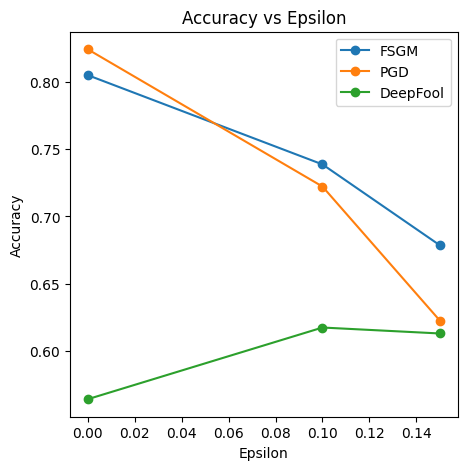

In [ ]:
#VGG16-FSGM-PGD plot
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_FSGM, "o-")
plt.plot(epsilons, accuracies_PGD, "o-")
plt.plot(epsilons, accuracies_DF, "o-")


plt.legend(['FSGM', 'PGD' , 'DeepFool'])
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


###VGG16-CW2 plot

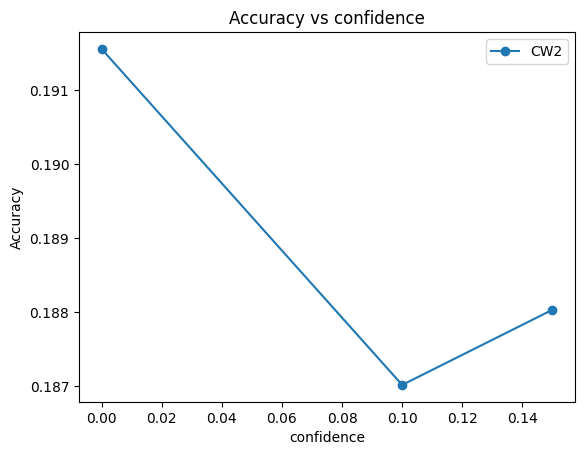

In [ ]:
plt.plot(kap, accuracies_CW2, "o-")
plt.legend(['CW2'])
plt.title("Accuracy vs confidence")
plt.xlabel("confidence")
plt.ylabel("Accuracy")
plt.show()

###FSGM-VGG16 image plot

<ipython-input-55-d8d3ffe73511>:13: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left, bottom, right, top, wspace, hspace)


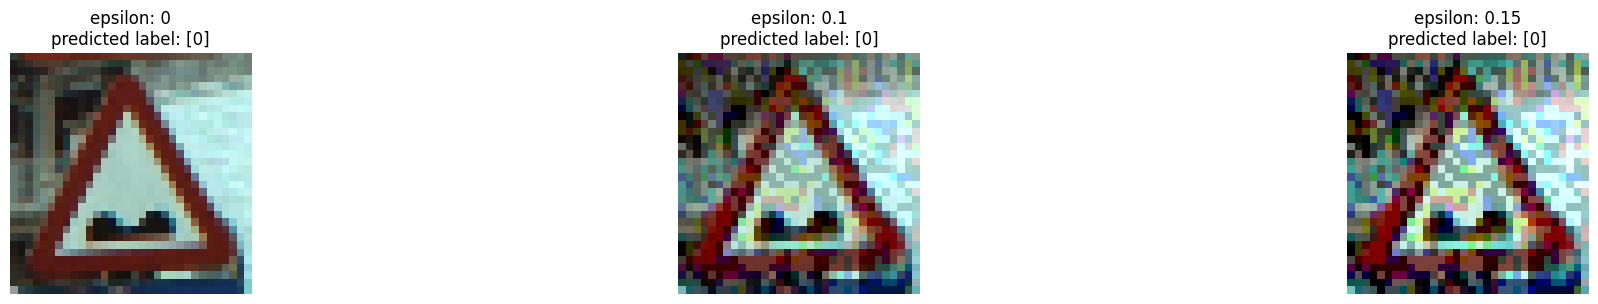

In [ ]:
#FSGM- VGG16- image plot

sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)
plt.figure(figsize=(20,15), constrained_layout=True)
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for data in subsest_dataloader:
  for epsilon in epsilons:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = fast_gradient_method(VGG16, images, epsilon, np.inf)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 3, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))

    plt.axis('off')
    cnt +=1
  break

#ResNet50

###FSGM-ResNet50

In [ ]:
#FGSM- ResNet50
total = 0
correct = 0
accuracies =[]
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = fast_gradient_method(ResNet50, images, epsilon, np.inf)
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies.append(np.mean(accuracy))
print(accuracies)


0
0.1
0.15
[0.861875, 0.5104878048780488, 0.33825757575757576]


###PGD-ResNet50

In [ ]:
#PGD- ResNet50
correct = 0
total = 0
accuracies =[]
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = projected_gradient_descent(model_fn = ResNet50, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf)
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies.append(np.mean(accuracy))
print(accuracies)

0
0.1
0.15
[0.861875, 0.504939024390244, 0.3346969696969697]


In [ ]:
#DeepFool
accuracies_DF = []
ResNet50_RS = PyTorchClassifier(model=ResNet50, loss=nn.CrossEntropyLoss(), nb_classes=62, input_shape=(3, 32, 32), device_type='gpu')

sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

correct = 0
total = 0
correct_attack = 0
for epsilon in tqdm(epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    adversarial_images = DeepFool(ResNet50_RS, epsilon= epsilon, batch_size = 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:art.attacks.evasion.deepfool:The `clip_values` attribute of the estimator is `None`, therefore this instance of DeepFool will by default generate adversarial perturbations scaled for input values in the range [0, 1] but not clip the adversarial example.


0


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [01:02<02:05, 62.53s/it]WARNING:art.attacks.evasion.deepfool:The `clip_values` attribute of the estimator is `None`, therefore this instance of DeepFool will by default generate adversarial perturbations scaled for input values in the range [0, 1] but not clip the adversarial example.


0.1


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [01:58<00:58, 58.67s/it]WARNING:art.attacks.evasion.deepfool:The `clip_values` attribute of the estimator is `None`, therefore this instance of DeepFool will by default generate adversarial perturbations scaled for input values in the range [0, 1] but not clip the adversarial example.


0.15


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 3/3 [03:48<00:00, 76.19s/it]

[0.2084375, 0.3069512195121951, 0.3308333333333333]


In [ ]:
#CW2
accuracies_CW2 = []
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
kap = [0, 0.1, 0.5, 1.0]
correct = 0
total = 0
correct_attack = 0
for k in tqdm(kap):
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    adversarial_images = CarliniL2Method(ResNet50_RS, confidence = k, learning_rate = 0.001, max_iter = 7, batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)


  0%|          | 0/4 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [01:26<04:19, 86.37s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 2/4 [02:51<02:51, 85.85s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [04:16<01:25, 85.42s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 4/4 [05:41<00:00, 85.34s/it]

[0.0484375, 0.04939024390243903, 0.04962121212121212, 0.04972527472527473]


###DF-FSGM-PGD-ResNet50 plot

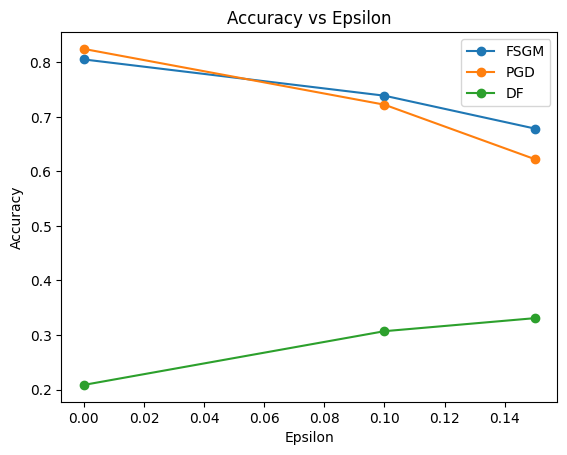

In [ ]:
plt.plot(epsilons, accuracies_FSGM, "o-")
plt.plot(epsilons, accuracies_PGD, "o-")
plt.plot(epsilons, accuracies_DF, "o-")

plt.legend(['FSGM', 'PGD', 'DF'])
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

###CW2-ResNet50 plot

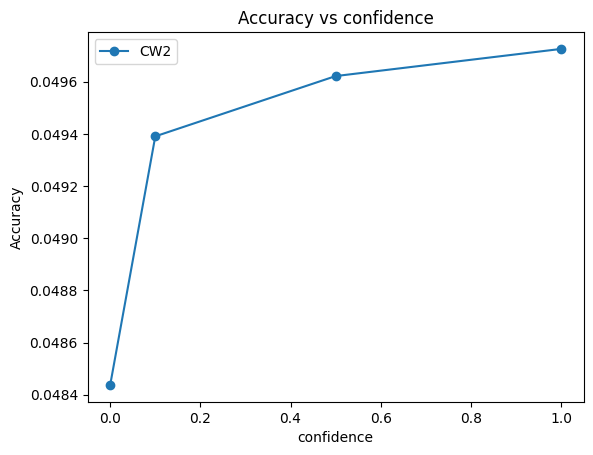

In [ ]:
plt.plot(kap, accuracies_CW2, "o-")
plt.legend(['CW2'])
plt.title("Accuracy vs confidence")
plt.xlabel("confidence")
plt.ylabel("Accuracy")
plt.show()

###FSGM-ResNet50 image plot

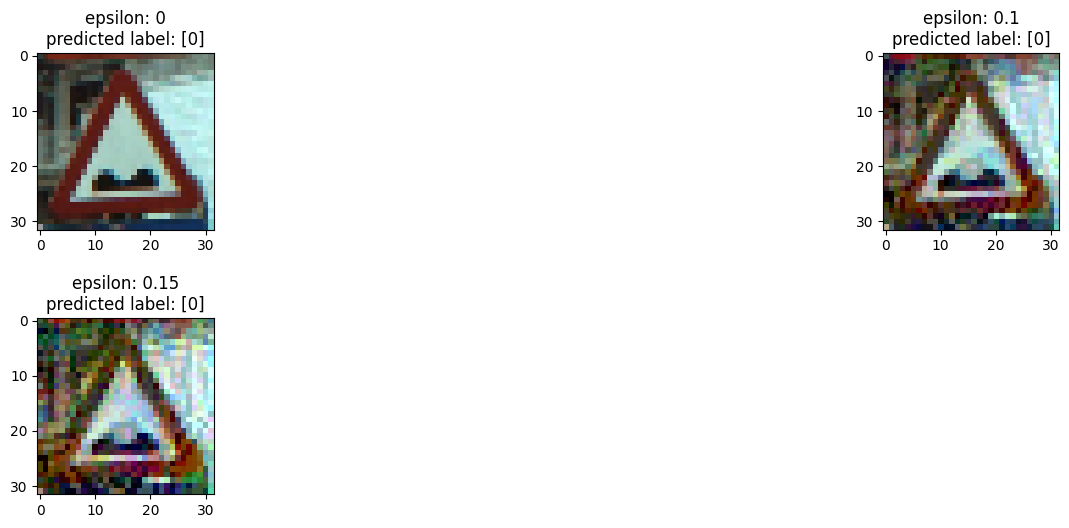

In [ ]:
#FSGM- ResNet50- image plot
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)
plt.figure(figsize=(20,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for data in subsest_dataloader:
  for epsilon in epsilons:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = projected_gradient_descent(model_fn = ResNet50, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf)
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
  break



#Results and discussion:


 Table 2.1- Attack accuracy for FGSM, PGD, and DeepFool

\begin{array}{|c|c|c|c|c|}
\hline
\textbf{Model} & \text{Adversarial Images(%) $\epsilon = \frac{5}{255}$}
& \text{Adversarial Images(%) $\epsilon = \frac{10}{255}$}
& \text{Adversarial Images(%) $\epsilon = \frac{20}{255}$} \\
\hline
\textbf{VGG16 - FGSM}  & 56.96\ & 45.48\ & 36.30\\\
\textbf{VGG16 - PGD}  & 45.14\ & 31.14\ & 24.39\\\
\textbf{VGG16 - DeepFool}  & 24.45\ & 26.19\ & 26.97\\\
\textbf{ResNet50 - FGSM}  & 74.63\ & 63\ & 51.16\\\
\textbf{ResNet50 - PGD}  & 69.55\ & 56.20\ & 36.47 \\
\textbf{ResNet50 - DeepFool}  & 17.20\ & 14.24\ & 12.85\\
\hline
\end{array}

On every test, DeepFool performs better than PGD and FGSM. Also, PGD has better performance in compare with FGSM.

 Table 2.2- Attack accuracy for CW2

\begin{array}{|c|c|c|c|c|}
\hline
\textbf{Model} & \text{Adversarial Images(%) $Confidence = 0.1$}
& \text{Adversarial Images(%) $Confidence = 0.5$}
& \text{Adversarial Images(%) $Confidence = 1$} \\
\hline
\textbf{VGG16 - CW2}  & 0\ & 0\ & 0\\\
\textbf{ResNet50 - CW2}  & 11.09\ & 10.32\ & 9.96 \\
\hline
\end{array}

CW2 has the best performance among all attacks used in this test.

##1- Targeted PGD

###VGG16

#### Accuracy on Label 21- Stop sign

In [ ]:
#PGD-VGG16
total = 0
correct = 0
list1 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list1.append(i)
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list1)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = VGG16, x =images,
                                                    eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

0
0.1
0.15
[0.9333333333333333, 0.5444444444444444, 0.37777777777777777]


#### Accuracy on Label 32- speed limit

In [ ]:
#PGD-VGG16
total = 0
correct = 0
list2 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list2.append(i)
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list2)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = VGG16, x =images,
                                                    eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

0
0.1
0.15
[0.0, 0.0811159635593259, 0.2201041058949966]


####PGD- VGG16 image plot

0
0.1


0.15


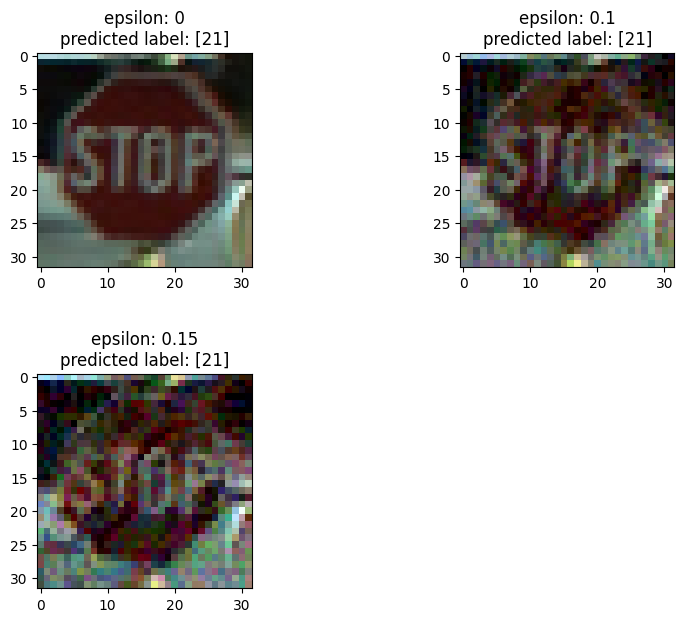

In [ ]:
#PGD- VGG16- image plot
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list1)
subset_dataloader = DataLoader(sub_dataset, batch_size=1)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subset_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = VGG16, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(5, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break

### ResNet50

#### Accuracy on label 21

In [ ]:
#ResNet50- PGD
total = 0
correct = 0
list4 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list4.append(i)
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list4)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = ResNet50, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

0
0.1
0.15
[0.9111111111111111, 0.4666666666666667, 0.3111111111111111]


#### Accuracy on Label 32

In [ ]:
#ResNet50- PGD
total = 0
correct = 0
list5 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list5.append(i)
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list5)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = ResNet50, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

0
0.1
0.15
[0.0, 0.2996324275002337, 0.545791766681417]


####PGD- ResNet50 Image plot

0
0.1


0.15


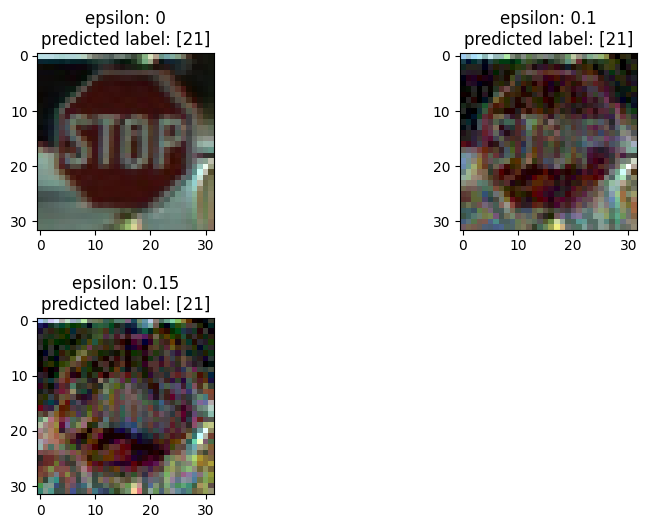

In [ ]:
#ResNet50- PGD- Image plot
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list4)
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  # skip = True
  for data in subsest_dataloader:
    #if skip:
    #  skip = False
    #  continue
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = ResNet50, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break



##2- Targeted FGSM

### VGG16

#### Accuracy on label 21

In [ ]:
#VGG16- FGSM
total = 0
correct = 0
list6 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list6.append(i)
accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list6)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = VGG16, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_FGSM.append(np.mean(accuracy))
print(accuracies_FGSM)

0
0.1
0.15
[0.9111111111111111, 0.7222222222222222, 0.6370370370370371]


#### Accuracy on Label 32

In [ ]:
#VGG16- FGSM
total = 0
correct = 0
list7 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list7.append(i)
accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list7)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = VGG16, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_FGSM.append(np.mean(accuracy))
print(accuracies_FGSM)

0
0.1
0.15
[0.0, 0.0007497377229815224, 0.0013823202232761751]


#### FGSM-VGG16 image plot

0
0.1
0.15


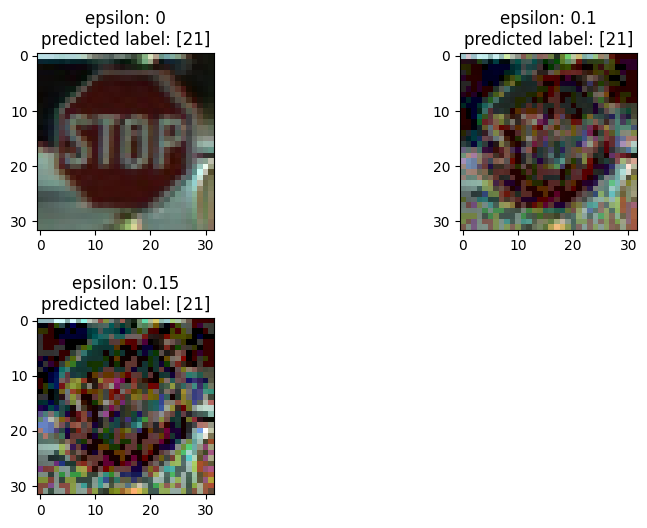

In [ ]:
#VGG16- FGSM- Image plot
accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list6)
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  # skip = True
  for data in subsest_dataloader:
    #if skip:
    #  skip = False
    #  continue
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = VGG16, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break



###ResNet50

####Accuracy on label 21

In [ ]:
#ResNet50- FGSM
correct = 0
total = 0
list8 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list8.append(i)
accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list8)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = ResNet50, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_FGSM.append(np.mean(accuracy))
print(accuracies_FGSM)

0
0.1
0.15
[0.9111111111111111, 0.5111111111111111, 0.37037037037037035]


####Accuracy on label 32

In [ ]:
#ResNet50- FGSM
correct = 0
total = 0
list9 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list9.append(i)
accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list9)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = ResNet50, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_FGSM.append(np.mean(accuracy))
print(accuracies_FGSM)

0
0.1
0.15
[0.0, 0.0, 0.0]


#### FSGM-ResNet50 image plot

0
0.1
0.15


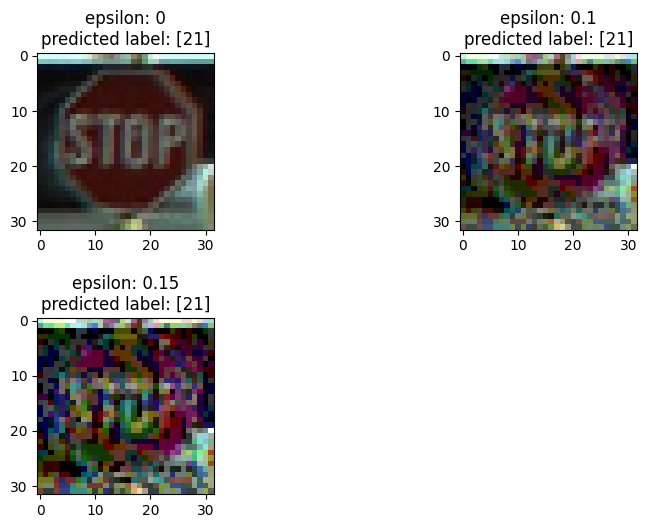

In [ ]:
#ResNet50- FGSM- Image plot
#accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list8)
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  skip = True
  for data in subsest_dataloader:
    if skip:
      skip = False
      continue
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = ResNet50, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break



##Targeted DeepFool

###VGG16

####Acuuracy on label 21

In [ ]:
#DF-VGG16
total = 0
correct = 0
list10 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list10.append(i)
accuracies_DF =[]
sub_dataset = Subset(test_dataset, list10)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(VGG16T, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)

  0%|          | 0/3 [00:00<?, ?it/s]WARNING:art.attacks.evasion.deepfool:The `clip_values` attribute of the estimator is `None`, therefore this instance of DeepFool will by default generate adversarial perturbations scaled for input values in the range [0, 1] but not clip the adversarial example.


0


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:54<01:48, 54.07s/it]WARNING:art.attacks.evasion.deepfool:The `clip_values` attribute of the estimator is `None`, therefore this instance of DeepFool will by default generate adversarial perturbations scaled for input values in the range [0, 1] but not clip the adversarial example.


0.1


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [01:47<00:53, 53.69s/it]WARNING:art.attacks.evasion.deepfool:The `clip_values` attribute of the estimator is `None`, therefore this instance of DeepFool will by default generate adversarial perturbations scaled for input values in the range [0, 1] but not clip the adversarial example.


0.15


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 3/3 [02:41<00:00, 53.70s/it]

[0.7333333333333333, 0.7333333333333333, 0.7333333333333333]


####Accuracy on label 32

In [ ]:
#DF-VGG16
total = 0
correct = 0
list11 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list11.append(i)
accuracies_DF =[]
sub_dataset = Subset(test_dataset, list11)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(VGG16T, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)

  0%|          | 0/3 [00:00<?, ?it/s]WARNING:art.attacks.evasion.deepfool:The `clip_values` attribute of the estimator is `None`, therefore this instance of DeepFool will by default generate adversarial perturbations scaled for input values in the range [0, 1] but not clip the adversarial example.


0


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [04:14<08:29, 254.80s/it]WARNING:art.attacks.evasion.deepfool:The `clip_values` attribute of the estimator is `None`, therefore this instance of DeepFool will by default generate adversarial perturbations scaled for input values in the range [0, 1] but not clip the adversarial example.


0.1


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [08:29<04:14, 254.86s/it]WARNING:art.attacks.evasion.deepfool:The `clip_values` attribute of the estimator is `None`, therefore this instance of DeepFool will by default generate adversarial perturbations scaled for input values in the range [0, 1] but not clip the adversarial example.


0.15


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 3/3 [12:44<00:00, 254.88s/it]

[0.0, 0.0, 0.0]


#### DF-VGG16 image plot

In [ ]:
#DF- VGG16- image plot

sub_dataset = Subset(test_dataset, list10)
subset_dataloader = DataLoader(sub_dataset, batch_size=1)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(VGG16T, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(5, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break




  0%|          | 0/3 [00:00<?, ?it/s]WARNING:art.attacks.evasion.deepfool:The `clip_values` attribute of the estimator is `None`, therefore this instance of DeepFool will by default generate adversarial perturbations scaled for input values in the range [0, 1] but not clip the adversarial example.


0


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:34<01:08, 34.01s/it]WARNING:art.attacks.evasion.deepfool:The `clip_values` attribute of the estimator is `None`, therefore this instance of DeepFool will by default generate adversarial perturbations scaled for input values in the range [0, 1] but not clip the adversarial example.


0.1


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

###ResNet50

####Accuracy on label 21

In [ ]:
#DF-ResNet50
total = 0
correct = 0
list12 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list12.append(i)
accuracies_DF =[]
sub_dataset = Subset(test_dataset, list12)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(ResNet50_RS, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)

####Accuracy on label 32

In [ ]:
#DF-ResNet50
total = 0
correct = 0
list13 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list13.append(i)
accuracies_DF =[]
sub_dataset = Subset(test_dataset, list13)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(ResNet50_RS, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)

#### DF-ResNet50 image plot

In [ ]:
#DF- ResNet50- image plot

sub_dataset = Subset(test_dataset, list12)
subset_dataloader = DataLoader(sub_dataset, batch_size=64)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(ResNet50_RS, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(5, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break




##Targeted CW2

###VGG16

####Accuracy for label 21






In [ ]:
#CW2-VGG16
total = 0
correct = 0
list14 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list14.append(i)
accuracies_CW2 =[]
sub_dataset = Subset(test_dataset, list14)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
kap = [0, 0.1, 0.5, 1.0]
for k in tqdm (kap):

  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(VGG16T, confidence = k,
                                         learning_rate = 0.01,
                                         max_iter = 7,
                                         batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)

####Accuracy for label 32

In [ ]:
#CW2-VGG16
total = 0
correct = 0
list15 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list15.append(i)
accuracies_CW2 =[]
sub_dataset = Subset(test_dataset, list15)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
kap = [0, 0.1, 0.5, 1.0]

for k in tqdm (kap):

  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(VGG16T, confidence = k,
                                         learning_rate = 0.01,
                                         max_iter = 7,
                                         batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)

#### CW2-VGG16 image plot

In [ ]:
#CW2- VGG16- image plot

sub_dataset = Subset(test_dataset, list14)
subset_dataloader = DataLoader(sub_dataset, batch_size=64)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
kap = [0, 0.1, 0.5, 1.0]

for k in tqdm (kap):

  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(VGG16T, confidence = k,
                                         learning_rate = 0.01,
                                         max_iter = 7,
                                         batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(5, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('confidence: '+ str(k)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break




###ResNet50

####Accuracy for label21

In [ ]:
#CW2-ResNet50
total = 0
correct = 0
list16 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list16.append(i)
accuracies_CW2 =[]
sub_dataset = Subset(test_dataset, list16)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
kap = [0, 0.1, 0.5, 1.0]

for k in tqdm (kap):
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(ResNet50_RS, confidence = k, learning_rate = 0.001, max_iter = 7, batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)

####Accuracy for label 32

In [ ]:
#CW2-ResNet50
total = 0
correct = 0
list17 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list17.append(i)
accuracies_CW2 =[]
sub_dataset = Subset(test_dataset, list17)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for k in tqdm (kap):
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(ResNet50_RS, confidence = k, learning_rate = 0.001, max_iter = 7, batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)

#### CW2-ResNet50 image plot

In [ ]:
#CW2- ResNet50- image plot

sub_dataset = Subset(test_dataset, list16)
subset_dataloader = DataLoader(sub_dataset, batch_size=64)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for k in tqdm (kap):
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(ResNet50_RS, confidence = k, learning_rate = 0.001, max_iter = 7, batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(5, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('confidence: '+ str(k)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break




# Result:

Table 3
Accuracies on adversarial targeted PGD attack on Stop Sign Image (label 21) and Speed Limit 70 Sign Images (label 32) on VGG16


\begin{array}{|c|c|c|}
\hline
\textbf{Perturbation Level} & \text{PGD Attack - Stop Sign Images(%)} & \text{PGD Attack - Speed Limit 70 Sign Images(%)} \\
\hline
\epsilon = \frac{5}{255} & 88.88\ & 0\ \\
\epsilon = \frac{10}{255} & 73.33\ & 0.17\ \\
\epsilon = \frac{20}{255} & 59.44\ & 2.34\ \\
\epsilon = \frac{50}{255} & 47.55\ & 6.29\ \\
\hline
\end{array}